# Deep Learning with Python
# 5.2.4 - Feature Extraction

## VGG 16 Conv Base - Feature Extraction
Will be using the convolutional base of the VGG16 model that was trained on 1M images belonging to 1,000 different classes of the ImageNet database.

Feature extraction means we'll use the generic, repurposable representations learnt by the convolutional base of a pre-trained model to extract useful featues for a new densely connected classifier that will be trained from scratch.

We don't use the densely connected classifier because 
- it has learnt representations that are neither translation invariant nor spatially hierarchical. 
- it has learnt representations that are specific to the class the model was originally trained on, and are likely to be irrelevant for the classes of our problem.
- it does not preserve information about the location or position of objects in the original image. 

On the other hand, the convolutional base
- has learnt highly generic, abstract features that are relevant across most classification problems e.g. edges, eyes, textures.
- has learnt representations that are translation invariant.
- has learnt representations that are spatially hierarchical - it preserves information about how low-level features combine to form high-level features


If the convolutional base was trained on a large enough dataset, its representations are a sufficiently generic to be models of the real world. This makes it more generic, repurposable, and reusable.

But this is only true if the data that the model was initially trained on is at least somewhat similar to the data for your problem. If it differs too much from the original training data, then you are better off training the convolutional base from scratch. Or, at most, use only the first few layers of the convolutional base that will have learnt the most generic features (hyperlocal edges, diagonals, etc.).

In [1]:
from tensorflow.keras.applications import VGG16

Description of params for `VGG16` initializer
- `weights`: Specifying which dataset/checkpoint the model should be initialized from
- `include_top`: Whether or not to include the densely connected classifier in the instantiated model
- `input_shape`: shape of the image tnesors that will be fed to the network. Optional argument. If unspecified, the network will be able to process inputs of any size.

In [2]:
conv_base = VGG16(weights='imagenet', 
                 include_top=False, 
                 input_shape=(150, 150, 3))

Instructions for updating:
Colocations handled automatically by placer.


### Convolutional Base Summary

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## Fast Feature Extraction - No Augmentation
- Use the convolutional base to produce input for training a densely connected classifier (from scratch).
- Involves running all data through the convolutional base and then recording the output as a `numpy` tensor that will then act as the input to a classifier. 
- Cheap: only the classifier's weights are optimized through gradient descent.
- Data augmentation not possible (why???)

In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Defining Directories for Data Generator

In [5]:
base_dir = '/Users/saads/OneDrive/Desktop/DL-Python/chapter-5/ch-5-repeat/cats_dogs_small'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
validation_dir = os.path.join(base_dir, 'validation')

### Data Generator for ConvBase I/P 

In [6]:
# The only transformation is rescaling all pixels to [0, 1] range
datagen = ImageDataGenerator(rescale=1./255)

# Global variable used in defining DataGenerator O/P later
batch_size=20

In [7]:
def extract_features(directory, sample_count):
    # Empty array to store O/Ps of convolutional base predictions
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    
    # Data generator will also provide labels for these I/Ps
    labels = np.zeros(shape=(sample_count))
    
    # Instantiating a generator that will process images as `numpy` arrays 
    # of 150 px by 150px in batches of 20 images. Labels that this will produce
    # will be either 0 or 1, depending on variants of the names in the target directory
    generator = datagen.flow_from_directory(
        directory, 
        target_size=(150, 150), 
        batch_size=batch_size, 
        class_mode='binary')
    
    # Batch counter 
    i = 0
    
    # For every batch of inputs and labels produced by the generator
    for inputs_batch, labels_batch in generator:
        # Features will be the output generated by the conv base for training data as I/P
        features_batch = conv_base.predict(inputs_batch)
        
        # Append features (convbase outputs) for each batch into the same array's rows
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        
        # Increment the number of batches processed
        i += 1
        
        # Total number of images generated = batch size * batch counter
        # If this exceeds the sample count specified for the directory
        # We have iterated over all training samples - conv base must see every
        # sample only once, so break the iteration process
        if i * batch_size >= sample_count:
            break
    
    # Return the extracted features and labels for use with the classifier
    return features, labels

In [8]:
train_features, train_labels = extract_features(train_dir, 2000)

Found 2000 images belonging to 2 classes.


In [9]:
validation_features, validation_labels = extract_features(validation_dir, 1000)

Found 1000 images belonging to 2 classes.


In [10]:
test_features, test_labels = extract_features(test_dir, 1000)

Found 1000 images belonging to 2 classes.


Extracting features and training labels will take some time because we're using a convolutional network with 14 M parameters to extract a multidimensional tensor of features and labels.

Before the Convolution Base's features can be fed into the densely connected classifier, it must be flattened. This is usually done through a dot product with the convolution kernel for the netowrk, but in this case we'll just use reshaping. It's the same thing. 

**Why aren't we just using the `Flatten` layer?**

## Densely Connected Classifier

In [11]:
from tensorflow.keras import models, layers, optimizers

In [12]:
# Reshape all features before feeding them into the densely connected network
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))

In [13]:
model = models.Sequential()

# Using `dim` instead of `input_shape` because we don't know the exact number of samples
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))

# Droput layer for regularization
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
# Compile
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), 
             loss='binary_crossentropy', 
             metrics=['acc'])

In [23]:
# Fit the model
histoy = model.fit(train_features, train_labels, 
                   epochs=30, batch_size=20, 
                   validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 5s 3ms/sample - loss: 0.0859 - acc: 0.9700 - val_loss: 0.2417 - val_acc: 0.9010
Epoch 2/30
2000/2000 [==============================] - 6s 3ms/sample - loss: 0.0827 - acc: 0.9750 - val_loss: 0.2395 - val_acc: 0.8990
Epoch 3/30
2000/2000 [==============================] - 6s 3ms/sample - loss: 0.0816 - acc: 0.9755 - val_loss: 0.2413 - val_acc: 0.8990
Epoch 4/30
2000/2000 [==============================] - 6s 3ms/sample - loss: 0.0783 - acc: 0.9780 - val_loss: 0.2391 - val_acc: 0.9000
Epoch 5/30
2000/2000 [==============================] - 6s 3ms/sample - loss: 0.0807 - acc: 0.9745 - val_loss: 0.2392 - val_acc: 0.9000
Epoch 6/30
2000/2000 [==============================] - 6s 3ms/sample - loss: 0.0763 - acc: 0.9785 - val_loss: 0.2407 - val_acc: 0.9010
Epoch 7/30
2000/2000 [==============================] - 7s 3ms/sample - loss: 0.0723 - acc: 0.9830 - val_loss: 0.2503 - val_acc: 0.9050


In [24]:
# Save the model
model.save('vgg_16_no_aug.h5')

## Visualizing Results

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
# Extracting data from training history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

Text(0.5,1,'VGG 16 (No Augmentation) - Accuracy')

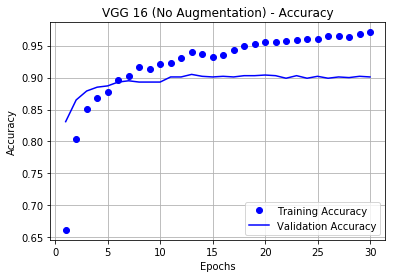

In [43]:
# Plotting accuracy
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend();
plt.title('VGG 16 (No Augmentation) - Accuracy')

Text(0.5,1,'VGG 16 (No Augmentation) - Loss')

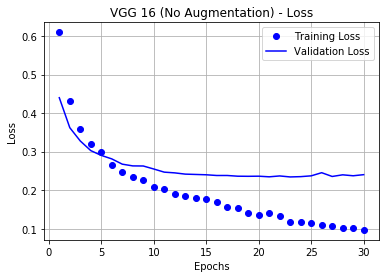

In [45]:
# Plotting loss
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.grid(True); plt.legend();
plt.title('VGG 16 (No Augmentation) - Loss')

## Feature Extraction with Data Augmentation

In [50]:
from tensorflow.keras import models, layers

In [56]:
new_model = models.Sequential()
new_model.add(conv_base)
new_model.add(layers.Flatten())
new_model.add(layers.Dense(256, activation='relu'))
new_model.add(layers.Dense(1, activation='sigmoid'))

In [57]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [59]:
print("This is the number of trainable weights before freezing the conv base ", len(model.trainable_weights)) # should be 30?

conv_base.trainable = False
    
print("This is the number of trainable weights after freezing the conv base", len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base  4
This is the number of trainable weights after freezing the conv base 4


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow.keras import optimizers

In [ ]:
train_datagen = ImageDataGenerator(
    rescale= 1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode='nearest')

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=20, 
    clas_s_mode='binary')

In [ ]:
validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150, 150), 
    batch_size=20, 
    class_mode='binary')

In [ ]:
model.compile(loss='binary_crossentropy', 
             optimizer=optimizers.RMSprop(lr=2e-5), 
             metrics=['acc'])

In [ ]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=100, 
    epochs=30,
    validation_data=validation_generator, 
    validation_steps=50
)

### Plotting VGG w/Data Augmentation Results

In [ ]:
# Extract data from history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

In [ ]:
# Plot Accuracy
plt.figure(); plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend();
plt.title('VGG Base with Augmentation - Accuracy');

In [ ]:
# Plot Loss
plt.figure(); plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.grid(True); plt.legend();
plt.title('VGG base with Augmentation - Loss'); 

# 5.25 - Fine Tuning
- Involves unfreezing a few of the top layers of convolutional base and training these layers along with the densely connected classifier.
- Called *fine tuning* because we're making small changes (gradient descent updates) to the weights for the top-most layers in the convolutional base.
- These weights encode the more abstract representations of the model being reused. So small changes to these models will only modify the model slightly for the specific problem we are trying to solve.

## Workflow
1. Add your custom network on top of an already-trained base network.
2. Freeze the base network.
3. Train the part you added. 
4. Unfreeze some layers in the base network.
5. Jointly train both these layers and the part you added.

The densely connected classifier for the model must be trained **before** the top-most layers are unfrozen. This ensures that the error signals propagating back through the classifier to the topmost CNN layers are small, and only **tune** their weights (and thus the representations they encode).

If the weights of the classifier were randomly initialized and not optimised before adding it to the convolutional base, the error signal generated by gradient descent would be too large. This large error signal would then backpropagate through the network and cause large changes in the weights of the topmost layers of the CNN. This would then lead to a complete loss of the representations encoded by these weights, and we wouldn't be fine-tuning the representations.

## Fine-Tuning Last Three Conv Layers
Don't fine-tune **all** layers because
- Only topmost layers need to be repurposed because they encode the most abstact, more specialized features.
- More layers => more parameters to train => more capacity => more risk of overfitting => risky on a small dataset.

In [25]:
# The densely connected classifier has already been trained.
# Unfreezing the entire convolutinal base and setting all layers
# Except a specific layer to trainable.
conv_base.trainable = True

In [26]:
# flag variable to control when the switch trainability logi
set_trainable = False

for layer in conv_base.layers:
    # If reached the last convolutional bloc
    if layer.name == 'block5_conv1':
        set_trainable = True    # change trainable flag state
    
    # Based on trainable flag, freeze/unfreeze the layer's weights
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [27]:
# Compiling the model with a new optimizer
model.compile(loss='binary_crossentropy', 
             optimizer=optimizers.RMSprop(lr=1e-5), 
             metrics=['acc'])

### Fine-Tuning

In [28]:
# Will have to use `fit_generator` because we are using the augmented model
# It is also possible to repurpose this code to use 
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=100, 
    epochs=100,    # because using the augmented model
    validation_data=validation_generator, 
    validation_steps=50)

NameError: name 'train_generator' is not defined

### Plotting Fine-Tuning Results

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc))

In [ ]:
# Accuracy
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.legend(); plt.grid(True); plt.xlabel('Epochs'); plt.ylabel('Accuracy')
plt.title('Fine-Tuned VGG16 Model: Accuracy');

In [22]:
# Loss
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.legend(); plt.grid(True); plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.title('Fine-Tuned VGG16 Model: Loss')

NameError: name 'plt' is not defined

## Moving Average Filter for Plots

In [30]:
# Implements a moving average filter for a set of data
def smooth_curve(points, factor=0.8):
    smoothed_points=[]     # new list to store smoothed data
    
    # For every data point in the original dataset
    for point in points:
        # If points have been smoothed before record the previous point
        # And add the weighted average to the data
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + (1 - factor) * point)
        # If this is the first point in the dataset
        else:
            smoothed_points.append(point)
    return smoothed_points

In [ ]:
# Plotting accuracy
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed Training Accuracy')
plt.plot(epochs, smooth_curve(val_acc), 'b-', label='Smoothed Validation Accuracy')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend();
plt.title('VGG16 with Fine-Tuning - Smoothed Accuracy')

In [ ]:
# Plotting loss
plt.figure(); plt.plot(epochs, smooth_curve(loss), label='Smoothed Training Loss')
plt.plot(epochs, smooth_curve(val_loss), label='Smoothed Validation Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.grid(True); plt.legend();
plt.title('VGG16 with Fine-Tuning - Smoothed Loss')

## Evaluating The Model

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(150, 150), 
    batch_size=20,
    class_mode='binary')

In [ ]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test accuracy: ', test_acc)